<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/figure_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook generate figure 8: the anatomical masks for the **cornu ammonis (CA) and dentate gyrus (DG) ROIs.** In addition, it also visualises the varying **probabilistic thresholds** and how we seperated the CA + DG ROI into **anterior** and **posterior** to later probe our functional gradient along the hippocampal long axis.

In [1]:
#!pip install nilearn
from nilearn import datasets, plotting, image, masking
import numpy as np
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 79.2 MB/s eta 0:00:00


In [2]:
# Load the MNI template brain for visualisation
mni = datasets.load_mni152_template()

In [3]:
# Fetch probabilistic Jülich atlas (1 mm)
julich = datasets.fetch_atlas_juelich("prob-1mm")  # or "maxprob-thr50-1mm"
labels = julich.labels

print("Number of labels:", len(labels))

[fetch_atlas_juelich] Added README.md to /root/nilearn_data

[fetch_atlas_juelich] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_juelich] Downloading data from https://www.nitrc.org/frs/download.php/12096/Juelich.tgz ...

[fetch_atlas_juelich] Downloaded 778240 of 3740787 bytes (20.8%%,    3.8s remaining)

[fetch_atlas_juelich]  ...done. (2 seconds, 0 min)

[fetch_atlas_juelich] Extracting data from /root/nilearn_data/fsl/5f0f3de71552237df29d0de14db5f8c8/Juelich.tgz...

[fetch_atlas_juelich] .. done.

Number of labels: 63


In [4]:
# Load Jülich probabilistic atlas
julich_prob = datasets.fetch_atlas_juelich("prob-1mm")
atlas_img = julich_prob.maps
labels = julich_prob.labels

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

In [5]:
# Helper function since without the background all indices are idx-1

def get_julich_roi(atlas_img, labels, query):
    """
    Retrieve a probabilistic ROI map from the Jülich atlas.

    Parameters
    ----------
    atlas_img : Nifti1Image
        The 4D probabilistic atlas (from fetch_atlas_juelich("prob-1mm")).
    labels : list of str
        Label names (includes "Background" at index 0).
    query : str
        Case-insensitive string to match (e.g. "subiculum").

    Returns
    -------
    roi_img : Nifti1Image
        The 3D probabilistic ROI image (values 0–100).
    idx : int
        The correct index in the 4D atlas (after Background correction).
    label : str
        The matched label string.
    """
    # Find label index (includes Background as [0])
    matches = [i for i, lab in enumerate(labels) if query.lower() in lab.lower()]
    if not matches:
        raise ValueError(f"No ROI found for query '{query}'.")

    # First match (you could extend this for multiple)
    label_idx = matches[0]
    map_idx = label_idx - 1  # Correct for Background
    if map_idx < 0:
        raise ValueError("Background is not a valid ROI.")

    roi_img = image.index_img(atlas_img, map_idx)
    return roi_img, map_idx, labels[label_idx]

In [6]:
# Function to split the ROI along the midline, which is x=0 in MNI space
# Other than in the HO atlas, the Jülich atlas does not automatically seperate the ROIs in LH and RH

def split_left_right(mask_img):
    """Split a bilateral ROI into left/right hemisphere masks."""
    data = mask_img.get_fdata()
    affine = mask_img.affine

    # Find voxel index corresponding to x=0
    x_voxel = int(round(np.linalg.inv(affine).dot([0, 0, 0, 1])[0]))

    left_data = np.zeros_like(data)
    right_data = np.zeros_like(data)

    left_data[:x_voxel, :, :] = data[:x_voxel, :, :]
    right_data[x_voxel:, :, :] = data[x_voxel:, :, :]

    left_img = image.new_img_like(mask_img, left_data, affine)
    right_img = image.new_img_like(mask_img, right_data, affine)
    return left_img, right_img

## Dentate Gyrus (DG)

In [7]:
# Get dentate gyrus (bilateral)
dg_img, idx, label = get_julich_roi(atlas_img, labels, "dentate gyrus")

In [8]:
# Split into hemispheres
dg_left, dg_right = split_left_right(dg_img)

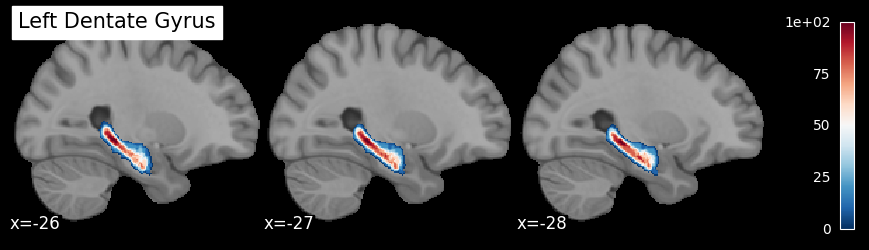

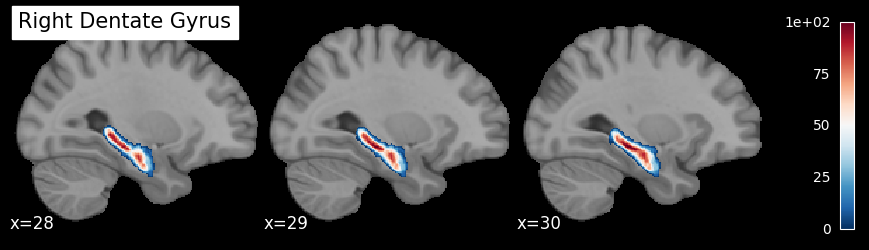

In [10]:
# Plot the dentate gyrus in LH and RH

plotting.plot_stat_map(dg_left, bg_img=datasets.load_mni152_template(),
                       title="Left Dentate Gyrus", display_mode="x", cut_coords=[-26,-27,-28],
                       threshold=0, vmax=100, draw_cross=False)

plotting.plot_stat_map(dg_right, bg_img=datasets.load_mni152_template(),
                       title="Right Dentate Gyrus", display_mode="x", cut_coords=[28,29,30],
                       threshold=0, vmax=100, draw_cross=False)

plotting.show()

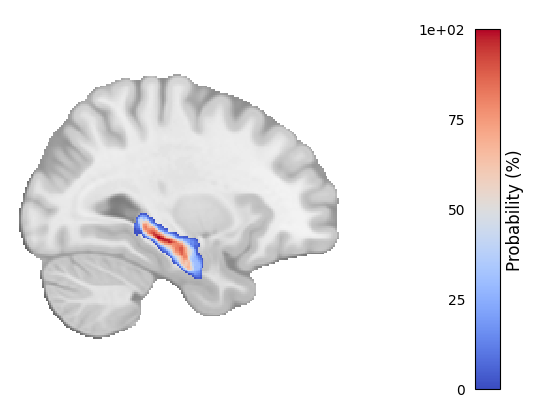

In [15]:
from nilearn import plotting, datasets, image
import matplotlib.pyplot as plt

# Load template
template = datasets.load_mni152_template()

# --- YOUR DG MAP ---
# dg_right = ...  # your probabilistic DG right mask

# Create clean white figure background
fig = plt.figure(figsize=(5, 4), facecolor='white')

# Use plot_stat_map with white background + one cut coord
display = plotting.plot_stat_map(
    dg_right,
    bg_img=template,
    display_mode="x",
    cut_coords=[30],        # only x = 30
    threshold=0,
    vmax=100,
    cmap="coolwarm",        # same as your screenshot
    draw_cross=False,
    annotate=False,
    black_bg=False,         # <-- white background
    figure=fig
)

# Add the colorbar
display._cbar.set_label("Probability (%)", fontsize=12)

# Optional: white margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

## Cornu Ammonis (CA)

In [11]:
# Get cornu ammonis (bilateral)
ca_img, idx, label = get_julich_roi(atlas_img, labels, "cornu ammonis")

In [12]:
# Split into hemispheres
ca_left, ca_right = split_left_right(ca_img)

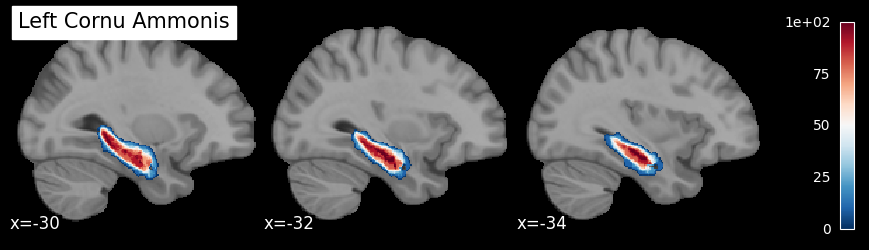

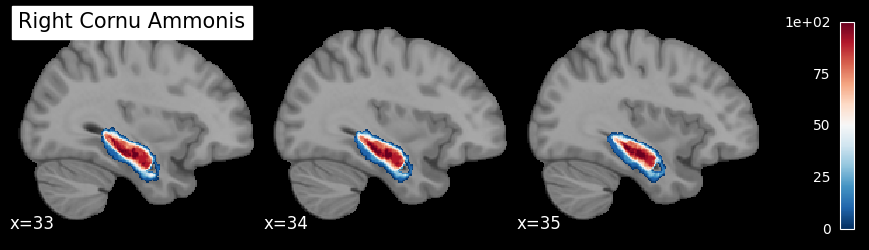

In [14]:
# Plot the cornu ammonis in LH and RH

plotting.plot_stat_map(ca_left, bg_img=datasets.load_mni152_template(),
                       title="Left Cornu Ammonis", display_mode="x", cut_coords=[-30,-32,-34],
                       threshold=0, vmax=100, draw_cross=False)

plotting.plot_stat_map(ca_right, bg_img=datasets.load_mni152_template(),
                       title="Right Cornu Ammonis", display_mode="x", cut_coords=[33,34,35],
                       threshold=0, vmax=100, draw_cross=False)

plotting.show()

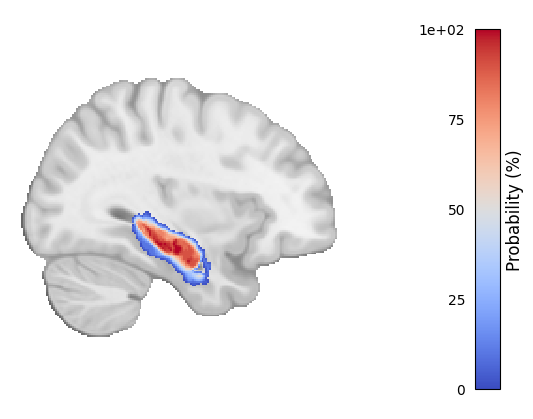

In [16]:
from nilearn import plotting, datasets, image
import matplotlib.pyplot as plt

# Load template
template = datasets.load_mni152_template()

# --- YOUR DG MAP ---
# dg_right = ...  # your probabilistic DG right mask

# Create clean white figure background
fig = plt.figure(figsize=(5, 4), facecolor='white')

# Use plot_stat_map with white background + one cut coord
display = plotting.plot_stat_map(
    ca_right,
    bg_img=template,
    display_mode="x",
    cut_coords=[33],        # only x = 33
    threshold=0,
    vmax=100,
    cmap="coolwarm",        # same as your screenshot
    draw_cross=False,
    annotate=False,
    black_bg=False,         # <-- white background
    figure=fig
)

# Add the colorbar
display._cbar.set_label("Probability (%)", fontsize=12)

# Optional: white margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

## Combine the CA and DG for the ROI mask

In [27]:
threshold = 50

In [28]:
from nilearn import image
import numpy as np

def combine_dg_ca_right(dg_right, ca_right, threshold=50):
    """
    Combine Dentate Gyrus (right hemisphere) and Cornu Ammonis (right hemisphere)
    using a probabilistic threshold.
    """

    dg_data = dg_right.get_fdata()
    ca_data = ca_right.get_fdata()

    # Apply threshold
    dg_thr = (dg_data >= threshold).astype(int)
    ca_thr = (ca_data >= threshold).astype(int)

    # Combine masks (logical OR)
    combined_data = ((dg_thr + ca_thr) > 0).astype(int)

    combined_img = image.new_img_like(dg_right, combined_data)

    return combined_img

In [29]:
combined_CA_DG_right = combine_dg_ca_right(dg_right, ca_right, threshold=50)

/tmp/ipython-input-2918871002.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  combined_img = image.new_img_like(dg_right, combined_data)


In [30]:
def best_sagittal_slice(mask_img):
    data = mask_img.get_fdata()
    sums = data.sum(axis=(1,2))
    best_x = np.argmax(sums)

    affine = mask_img.affine
    best_x_mm = affine[0,0]*best_x + affine[0,3]

    return best_x_mm

best_x_mm = best_sagittal_slice(combined_CA_DG_right)
print(best_x_mm)

31.0


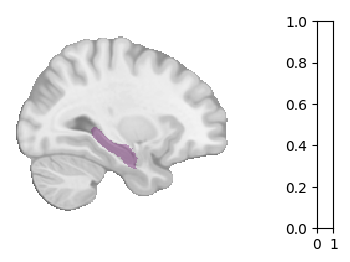

In [55]:
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting, datasets

purple_solid = LinearSegmentedColormap.from_list(
    "solid_purple",
    [(0, (0.5, 0.2, 0.5, 0.5)), (1, (0.5, 0.2, 0.5, 0.5))]
)

template = datasets.load_mni152_template()

display = plotting.plot_roi(
    combined_CA_DG_right,
    bg_img=template,
    display_mode="x",
    cut_coords=[30], # it looks the best for 31
    cmap=purple_solid,
    alpha=0.9,
    draw_cross=False,
    black_bg=False,
    annotate=False
)

In [38]:
print("dg_right max =", dg_right.get_fdata().max())
print("ca_right max =", ca_right.get_fdata().max())

print("DG voxels ≥50% =", (dg_right.get_fdata() >= 50).sum())
print("CA voxels ≥50% =", (ca_right.get_fdata() >= 50).sum())

dg_right max = 100.0
ca_right max = 100.0
DG voxels ≥50% = 2118
CA voxels ≥50% = 6012


## Split the combined ROI into anterior and posterior

In [58]:
mni_y = [-15, -27]   # anterior/posterior boundaries

In [59]:
colors = {
    "posterior": '#342d8bff',   # deep blue-ish purple
    "anterior":  '#ca406eff'    # magenta/pink
}

In [62]:
import numpy as np
from nilearn import image

def split_anterior_posterior(mask_img, y_bounds):
    """
    Split a unilateral hippocampal mask into anterior and posterior
    based on MNI y coordinates.

    y_bounds: list or tuple of two values [y_anterior, y_posterior]
       anterior mask = y >= y_bounds[0]
       posterior mask = y <= y_bounds[1]
    """

    y_ant, y_post = y_bounds
    data = mask_img.get_fdata()
    affine = mask_img.affine

    # Compute voxel y-coordinates in MNI space
    shape = data.shape
    xv, yv, zv = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )

    coords = np.vstack([xv.ravel(), yv.ravel(), zv.ravel(), np.ones(xv.size)])
    mni_coords = affine @ coords

    y_coords = mni_coords[1, :].reshape(shape)

    # Create anterior mask
    anterior = np.zeros_like(data)
    anterior[(data > 0) & (y_coords >= y_ant)] = 1

    # Create posterior mask
    posterior = np.zeros_like(data)
    posterior[(data > 0) & (y_coords <= y_post)] = 1

    # Convert back to NIfTI
    anterior_img = image.new_img_like(mask_img, anterior)
    posterior_img = image.new_img_like(mask_img, posterior)

    return anterior_img, posterior_img

In [63]:
anterior_img, posterior_img = split_anterior_posterior(
    combined_CA_DG_right,
    mni_y
)

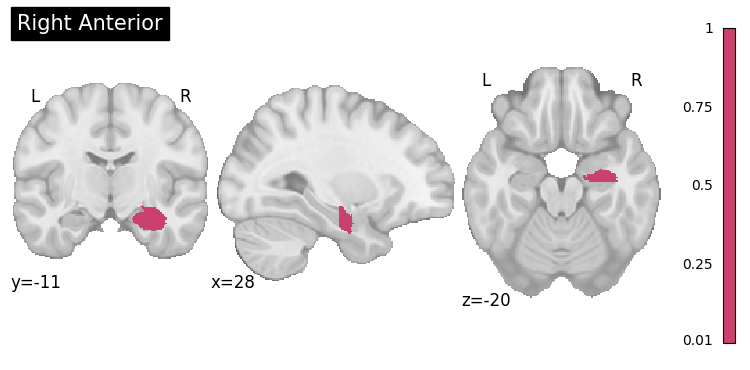

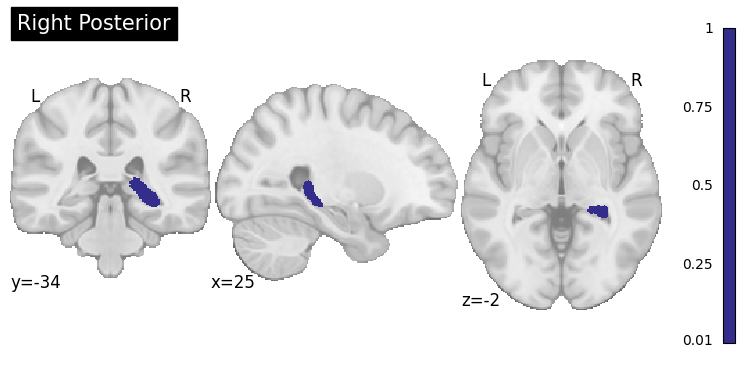

In [67]:
import matplotlib.colors as mcolors
from nilearn import plotting, datasets

template = datasets.load_mni152_template()

masks_img = {
    "right": {
        "anterior": anterior_img,
        "posterior": posterior_img
    }
}

colors = {
    "posterior": '#342d8bff',
    "anterior":  '#ca406eff'
}

for hemi in masks_img:
    for roi in masks_img[hemi]:
        cmap = mcolors.ListedColormap([
            [0, 0, 0, 0],          # fully transparent background
            colors[roi]            # your chosen RGBA color
        ])

        plotting.plot_stat_map(
            masks_img[hemi][roi],
            bg_img=template,
            draw_cross=False,
            threshold=0.01,
            black_bg=False,
            colorbar=True,
            #cut_coords=[31],
            cmap=cmap,
            vmin=0,
            vmax=1,
            title=f"{hemi.capitalize()} {roi.capitalize()}"
        )

    plotting.show()


In [85]:
import matplotlib.colors as mcolors

# Original opaque colors
colors_hex = {
    "anterior":  '#ca406eff',   # magenta/pink
    "posterior": '#342d8bff'    # blue-purple
}

# Make them more transparent
colors_transparent = {
    roi: mcolors.to_rgba(col, alpha=0.62)   # you can adjust this alpha as you like
    for roi, col in colors_hex.items()
}

In [86]:
def make_transparent_cmap(color_rgba):
    return mcolors.ListedColormap([
        (0, 0, 0, 0),   # fully transparent outside ROI
        color_rgba      # soft colored ROI
    ])

In [87]:
from nilearn import plotting, datasets

template = datasets.load_mni152_template()

def plot_single_sagittal(mask_img, color_rgba, title=None):
    cmap = make_transparent_cmap(color_rgba)

    display = plotting.plot_stat_map(
        mask_img,
        bg_img=template,
        display_mode="x",
        cut_coords=[30],     # fixed coordinate
        cmap=cmap,
        threshold=0.01,
        black_bg=False,
        draw_cross=False,
        annotate=False,      # removes "x=..." text
        colorbar=False,      # remove the colorbar
        alpha=1.0,           # transparency is controlled by the colormap, not alpha
        title=title
    )

    return display

/tmp/ipython-input-2667724335.py:8: UserWarning: kwargs['alpha']=1.0 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


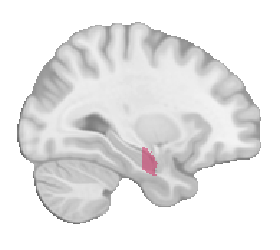

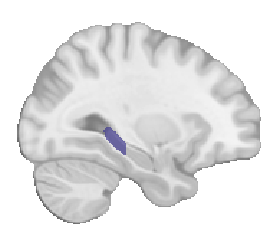

In [88]:
plot_single_sagittal(
    anterior_img,
    colors_transparent["anterior"],
    #title="Right Anterior"
)

plot_single_sagittal(
    posterior_img,
    colors_transparent["posterior"],
    #title="Right Posterior"
)